## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], regulizer_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(regulizer_ratio))(input_layer)        
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(regulizer_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])    
    return model

def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], regulizer_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(regulizer_ratio))(input_layer)        
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(regulizer_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])    
    return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [10]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], regulizer_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 12s 233us/step - loss: 2.4626 - accuracy: 0.0989 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 12s 233us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 12s 233us/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 15s 301us/step - loss: 2.8279 - accuracy: 0.6202 - val_loss: 3.0842 - val_accuracy: 0.5267
Epoch 46/50
50000/50000 [==============================] - 16s 310us/step - loss: 2.7844 - accuracy: 0.6212 - val_loss: 3.0125 - val_accuracy: 0.5301
Epoch 47/50
50000/50000 [==============================] - 13s 269us/step - loss: 2.7436 - accuracy: 0.6232 - val_loss: 3.0360 - val_accuracy: 0.5169
Epoch 48/50
50000/50000 [==============================] - 14s 272us/step - loss: 2.7072 - accuracy: 0.6264 - val_loss: 3.0070 - val_accuracy: 0.5207
Epoch 49/50
50000/50000 [==============================] - 12s 246us/step - loss: 2.6688 - accuracy: 0.6271 - val_loss: 3.0483 - val_accuracy: 0.5040
Epoch 50/50
50000/50000 [==============================] - 13s 258us/step - loss: 2.6358 - accuracy: 0.6282 - val_loss: 2.9073 - val_accuracy: 0.5287
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

50000/50000 [==============================] - 12s 244us/step - loss: 0.9653 - accuracy: 0.6620 - val_loss: 1.3673 - val_accuracy: 0.5302
Epoch 43/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.9497 - accuracy: 0.6679 - val_loss: 1.4238 - val_accuracy: 0.5127
Epoch 44/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.9437 - accuracy: 0.6679 - val_loss: 1.3686 - val_accuracy: 0.5307
Epoch 45/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.9268 - accuracy: 0.6755 - val_loss: 1.3736 - val_accuracy: 0.5352
Epoch 46/50
50000/50000 [==============================] - 12s 242us/step - loss: 0.9152 - accuracy: 0.6775 - val_loss: 1.4000 - val_accuracy: 0.5309
Epoch 47/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.9010 - accuracy: 0.6821 - val_loss: 1.3943 - val_accuracy: 0.5216
Epoch 48/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.8911 - accuracy: 0.6883 - va

50000/50000 [==============================] - 11s 228us/step - loss: 1.0150 - accuracy: 0.6418 - val_loss: 1.3900 - val_accuracy: 0.5138
Epoch 40/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.0001 - accuracy: 0.6483 - val_loss: 1.4020 - val_accuracy: 0.5176
Epoch 41/50
50000/50000 [==============================] - 11s 225us/step - loss: 0.9895 - accuracy: 0.6527 - val_loss: 1.3671 - val_accuracy: 0.5311
Epoch 42/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.9768 - accuracy: 0.6562 - val_loss: 1.3441 - val_accuracy: 0.5362
Epoch 43/50
50000/50000 [==============================] - 12s 233us/step - loss: 0.9626 - accuracy: 0.6621 - val_loss: 1.3930 - val_accuracy: 0.5235
Epoch 44/50
50000/50000 [==============================] - 11s 224us/step - loss: 0.9506 - accuracy: 0.6670 - val_loss: 1.5023 - val_accuracy: 0.5028
Epoch 45/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.9407 - accuracy: 0.6695 - va

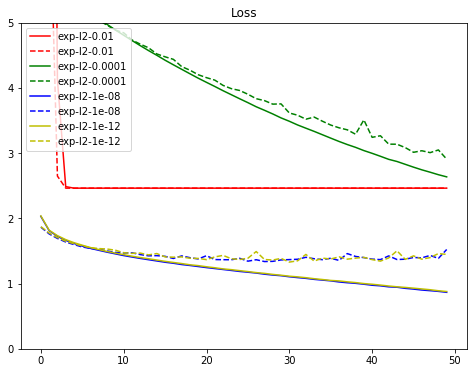

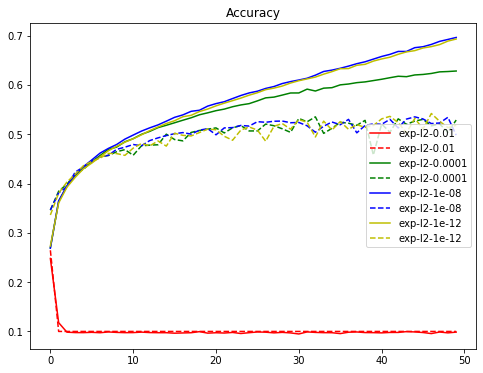

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], regulizer_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 11s 224us/step - loss: 1.6211 - accuracy: 0.5175 - val_loss: 1.6968 - val_accuracy: 0.4907
Epoch 49/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.6181 - accuracy: 0.5195 - val_loss: 1.7030 - val_accuracy: 0.4844
Epoch 50/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.6161 - accuracy: 0.5216 - val_loss: 1.6934 - val_accuracy: 0.4853
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 12s 230us/step - loss: 1.0789 - accuracy: 0.6726 - val_loss: 1.5665 - val_accuracy: 0.5134
Epoch 46/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.0680 - accuracy: 0.6757 - val_loss: 1.5545 - val_accuracy: 0.5166
Epoch 47/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.0555 - accuracy: 0.6813 - val_loss: 1.5385 - val_accuracy: 0.5156
Epoch 48/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.0413 - accuracy: 0.6843 - val_loss: 1.5681 - val_accuracy: 0.5191
Epoch 49/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.0296 - accuracy: 0.6910 - val_loss: 1.5300 - val_accuracy: 0.5294
Epoch 50/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.0166 - accuracy: 0.6940 - val_loss: 1.5741 - val_accuracy: 0.5196
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

50000/50000 [==============================] - 11s 220us/step - loss: 0.9737 - accuracy: 0.6567 - val_loss: 1.3627 - val_accuracy: 0.5326
Epoch 43/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.9561 - accuracy: 0.6648 - val_loss: 1.3634 - val_accuracy: 0.5308
Epoch 44/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.9492 - accuracy: 0.6662 - val_loss: 1.3970 - val_accuracy: 0.5250
Epoch 45/50
50000/50000 [==============================] - 11s 216us/step - loss: 0.9337 - accuracy: 0.6712 - val_loss: 1.3617 - val_accuracy: 0.5321
Epoch 46/50
50000/50000 [==============================] - 11s 214us/step - loss: 0.9232 - accuracy: 0.6770 - val_loss: 1.3965 - val_accuracy: 0.5226
Epoch 47/50
50000/50000 [==============================] - 11s 217us/step - loss: 0.9126 - accuracy: 0.6778 - val_loss: 1.4063 - val_accuracy: 0.5235
Epoch 48/50
50000/50000 [==============================] - 11s 219us/step - loss: 0.9011 - accuracy: 0.6845 - va

50000/50000 [==============================] - 11s 226us/step - loss: 1.0055 - accuracy: 0.6473 - val_loss: 1.4014 - val_accuracy: 0.5171
Epoch 40/50
50000/50000 [==============================] - 11s 221us/step - loss: 0.9912 - accuracy: 0.6524 - val_loss: 1.3734 - val_accuracy: 0.5275
Epoch 41/50
50000/50000 [==============================] - 11s 219us/step - loss: 0.9788 - accuracy: 0.6558 - val_loss: 1.3496 - val_accuracy: 0.5311
Epoch 42/50
50000/50000 [==============================] - 11s 224us/step - loss: 0.9639 - accuracy: 0.6635 - val_loss: 1.3664 - val_accuracy: 0.5327
Epoch 43/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.9593 - accuracy: 0.6625 - val_loss: 1.4019 - val_accuracy: 0.5214
Epoch 44/50
50000/50000 [==============================] - 11s 227us/step - loss: 0.9427 - accuracy: 0.6707 - val_loss: 1.3771 - val_accuracy: 0.5285
Epoch 45/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.9306 - accuracy: 0.6739 - va

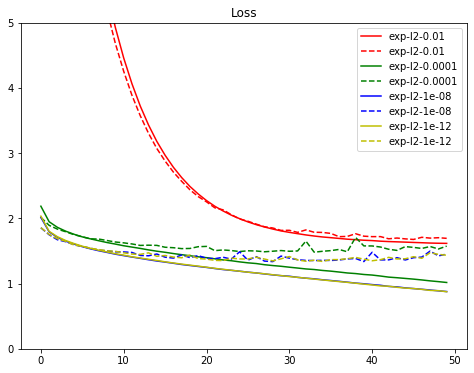

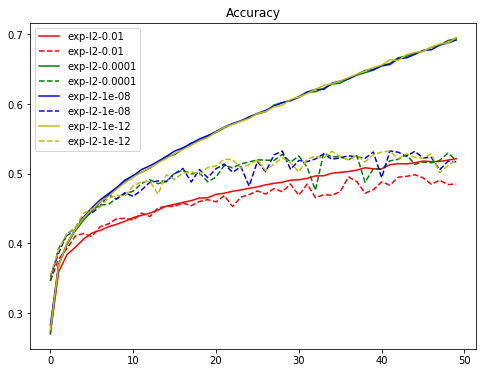

In [13]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()